# <center> Loopback Program and pulse generation in tproc V2

<center> In this demo you will perform a loopback test with different types of pulses.


Imports

In [ ]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

Connect to RFSoC using Pyro4

In [ ]:
import Pyro4
from qick import QickConfig
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

ns_host = "192.168.1.135"
ns_port = 8000
proxy_name = "rfsoc"

ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)

### Hardware Configuration

You should cable the board in loopback, connecting one DAC to one ADC. You can set appropriate generator and readout numbers in the cell below, which will be used in `res_ch` and `ro_ch` entries in the program dictionaries below.

For example, for a ZCU111 you might connect DAC229_T1_CH3 to ADC224_T0_CH0 (these are the labels on the XM500 balun board). The DAC and ADC lists tell you that these are DAC tile 1, block 3, and ADC tile 0, block 0. The generator and readout lists tell you that these are driven by generator 6 and readout 0, and your QICK programs will reference those IDs.

In [ ]:
# DAC Signal Generating Channels
GEN_CH0 = 0
GEN_CH1 = 1
GEN_CH2 = 2
GEN_CH3 = 3
GEN_CH4 = 4
GEN_CH5 = 5
GEN_CH6 = 6
GEN_CH7 = 7
GEN_CH8 = 8
GEN_CH9 = 9
GEN_CH10 = 10
GEN_CH11 = 11

# ADC Readout Channels
RO_CH0 = 0
RO_CH1 = 1
RO_CH2 = 2
RO_CH3 = 3
RO_CH4 = 4
RO_CH5 = 5

### Loopback Program
Setup the Loopback Program for a constant pulse

In [ ]:
##################
# Define Program #
##################

class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=2)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)
        
        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['pulse_len'], 
                       freq=cfg['freq'], 
                       phase=cfg['pulse_phase'],
                       gain=cfg['pulse_gain'],
                      )
    
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0)

In [ ]:
config = {
    ## Channel Params. ##
    'gen_ch': GEN_CH0,
    'ro_ch': RO_CH0,
    ## Pulse Params. ##
    'freq': 1000, # [MHz]
    'pulse_len': 0.1, # [us]
    'pulse_phase': 0, # [deg]
    'pulse_gain': 1.0, # [DAC units]
    ## Readout Params. ##
    'trig_time': 0.35, # [us]
    'ro_len': 0.3, # [us]
     }

###################
# Run the Program
###################

prog =LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

In [ ]:
# Plot results.
plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

### Rep-to-rep consistency
In this notebook we mostly use decimated readout (we acquire a full waveform, not just a single accumulated value). To avoid exhausting the waveform buffer, we usually run with reps=1 (the tProcessor program only fires+reads one pulse, and we run the program `soft_avgs` times).

However, it's important to check that if you run a tProcessor loop with reps>1, the pulse looks the same in each iteration of the loop. So let's do a decimated readout with multiple reps; the 1024-sample buffer will allow for 10 reps of 100 samples each.

Try changing the relax_delay to 0. You will see that the first rep appears in the same place, but the others are delayed by a bit because the tProcessor didn't have enough time between waiting for the measurement in one rep and firing the pulse in the next rep.

In [ ]:
config = {
    ## Channel Params. ##
    'gen_ch': GEN_CH0,
    'ro_ch': RO_CH0,
    ## Pulse Params. ##
    'freq': 1000, # [MHz]
    'pulse_len': 0.1, # [us]
    'pulse_phase': 0, # [deg]
    'pulse_gain': 1.0, # [DAC units]
    ## Readout Params. ##
    'trig_time': 0.35, # [us]
    'ro_len': 0.3, # [us]
     }

###################
# Run the Program
###################

prog =LoopbackProgram(soccfg, reps=10, final_delay=0.5, cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=100)
t = prog.get_time_axis(ro_index=0)

In [ ]:
plt.figure(1)
for ii, iq in enumerate(iq_list[0]):
    # plt.plot(iq[:,0], label="I value, rep %d"%(ii))
    # plt.plot(iq[:,1], label="I value, rep %d"%(ii))
    plt.plot(t, np.abs(iq[:,0]+1j*iq[:,1]), label="mag, rep %d"%(ii))
plt.ylabel("a.u.")
plt.xlabel("us")
plt.title("Sotware Averages = " + str(100))
plt.legend();

### Multiple triggers - Work in progress - santi
You can send multiple triggers inside a loop. The output data arrays will gain a dimension, corresponding to the trigger number.

Let's check the rep-to-rep consistency as well as the consistency between the first and second trigger.

In [ ]:
class DoubleTriggerProgram(AveragerProgramV2):
   
   def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=2)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)
        
        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['pulse_len'], 
                       freq=cfg['freq'], 
                       phase=cfg['pulse_phase'],
                       gain=cfg['pulse_gain'],
                      )
    
   def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0)
        
    # def body(self):
    #     # fire the same pulse+trigger twice, with 100 tProc clock ticks in between
    #     # with the first ADC trigger, pulse PMOD0_0 for a scope trigger
    #     # after the second pulse, pause the tProc until readout is done
    #     # and increment the time counter to give some time before the next measurement
    #     # (the syncdelay also lets the tProc get back ahead of the clock)
    #     self.measure(pulse_ch=self.cfg["res_ch"], 
    #                  adcs=self.ro_chs,
    #                  pins=[0], 
    #                  adc_trig_offset=self.cfg["adc_trig_offset"],
    #                  syncdelay=100)
    #     self.measure(pulse_ch=self.cfg["res_ch"], 
    #                  adcs=self.ro_chs,
    #                  adc_trig_offset=self.cfg["adc_trig_offset"],
    #                  wait=True,
    #                  syncdelay=self.us2cycles(self.cfg["relax_delay"]))

In [ ]:
config = {
    ## Channel Params. ##
    'gen_ch': GEN_CH0,
    'ro_ch': RO_CH0,
    ## Pulse Params. ##
    'freq': 1000, # [MHz]
    'pulse_len': 0.1, # [us]
    'pulse_phase': 0, # [deg]
    'pulse_gain': 1.0, # [DAC units]
    ## Readout Params. ##
    'trig_time': 0.35, # [us]
    'ro_len': 0.3, # [us]
     }

###################
# Run the Program
###################

prog = DoubleTriggerProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=100)
t = prog.get_time_axis(ro_index=0)

In [ ]:
plt.figure(1)
for rep in range(1):
    for trig in range(2):
        plt.plot(np.abs(iq_list[0][rep][trig][0]+1j*iq_list[0][rep][trig][1]), label="mag, rep %d trig %d"%(rep, trig))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();

### Send/receive a pulse with <code> pulse_style </code> = <code> flat_top </code>

In [ ]:
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['pulse_phase'],
                       gain=cfg['pulse_gain'], 
                      )
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

In [ ]:
config = {
    ## Channel Params. ##
    'gen_ch': GEN_CH0,
    'ro_ch': RO_CH0,
    ## Pulse Params. ##
    'freq': 1000, # [MHz]
    'flat_len': 0.1, # [us]
    'ramp_len': 0.3, # [us]
    'pulse_phase': 0, # [deg]
    'pulse_gain': 1.0, # [DAC units]
    ## Readout Params. ##
    'trig_time': 0.2, # [us]
    'ro_len': 1, # [us]
     }


prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=100)
t = prog.get_time_axis(ro_index=0)

In [ ]:
plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

### Send/receive a pulse with <code> pulse_style </code> = <code> arb </code>

In [ ]:
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mygaus", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=cfg['pulse_phase'],
                       gain=cfg['pulse_gain'], 
                      )
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

In [ ]:
config = {
    ## Channel Params. ##
    'gen_ch': GEN_CH0,
    'ro_ch': RO_CH0,
    ## Pulse Params. ##
    'freq': 1000, # [MHz]
    'ramp_len': 0.5, # [us]
    'pulse_phase': 0, # [deg]
    'pulse_gain': 1.0, # [DAC units]
    ## Readout Params. ##
    'trig_time': 0.2, # [us]
    'ro_len': 1, # [us]
     }


prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=100)
t = prog.get_time_axis(ro_index=0)

In [ ]:
plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

### Multiple pulses

Here's an example of playing multiple pulses back to back. In V2 you can define your pulses and then call on them at the time you want them output, as opposed to the V1 version where you could only define one pulse per generator at a time.

In [ ]:
class MultiPulseProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myflattop", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['pulse_phase'],
                       gain=cfg['pulse_gain'], 
                      )

        self.add_pulse(ch=gen_ch, name="mygaus", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=cfg['pulse_phase'],
                       gain=cfg['pulse_gain'], 
                      )

        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['pulse_len'], 
                       freq=cfg['freq'], 
                       phase=cfg['pulse_phase'],
                       gain=cfg['pulse_gain'],
                      )

        self.add_pulse(ch=gen_ch, name="myflattop2", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['pulse_phase'],
                       gain=cfg['pulse_gain'], 
                      )
        
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0.4)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0.8)
        self.pulse(ch=cfg['gen_ch'], name="myflattop2", t=1.2)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=1.6)

In [ ]:
config = {
    ## Channel Params. ##
    'gen_ch': GEN_CH0,
    'ro_ch': RO_CH0,
    ## Pulse Params. ##
    'freq': 1000, # [MHz]
    'pulse_len': 0.1, # [us]
    'pulse_phase': 0, # [deg]
    'pulse_gain': 1.0, # [DAC units]
    ## Readout Params. ##
    'trig_time': 0.2, # [us]
    'ro_len': 2.5, # [us]
     }


prog = MultiPulseProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=100)
t = prog.get_time_axis(ro_index=0)

In [ ]:
plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

### Multiplexed Output and Readout

In [40]:
class MuxProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1, ro_ch=ro_chs[0], 
                         mixer_freq=cfg['mixer_freq'],
                         mux_freqs=cfg['freq'], 
                         mux_gains=cfg['pulse_gain'], 
                         mux_phases=cfg['pulse_phase'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['freq'], cfg['ro_phase']):
            self.declare_readout(ch=ch, length=cfg['ro_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mymux", 
                       style="const", 
                       length=cfg["pulse_len"],
                       mask=[0,1,2,3],
                      )
        
    def _body(self, cfg):
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'], ddr4=True)

        self.pulse(ch=cfg['gen_ch'], name="mymux", t=0)

In [44]:
config = {
    ## Channel Params. ##
    'gen_ch': GEN_CH10,
    'ro_chs': [RO_CH2, RO_CH3, RO_CH4, RO_CH5],
    ## Pulse Params. ##
    'freq': [7150, 7175, 7200, 7225], # [MHz]
    'pulse_len': 0.1, # [us]
    'pulse_phase': [0.0]*4, # [deg]
    'pulse_gain': [1.0]*4, # [DAC units]
    'mixer_freq': 7000, # [MHz]
    ## Readout Params. ##
    'trig_time': 0.2, # [us]
    'ro_len': 1, # [us]
    'ro_phase': [0.0]*4, # [deg]
     }

prog = MuxProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

generator 10 doesn't support phase config, but mux_phases was defined
The readout at 7225.000 MHz may see some crosstalk from the tone at 7200.000 MHz.


  0%|          | 0/1 [00:00<?, ?it/s]

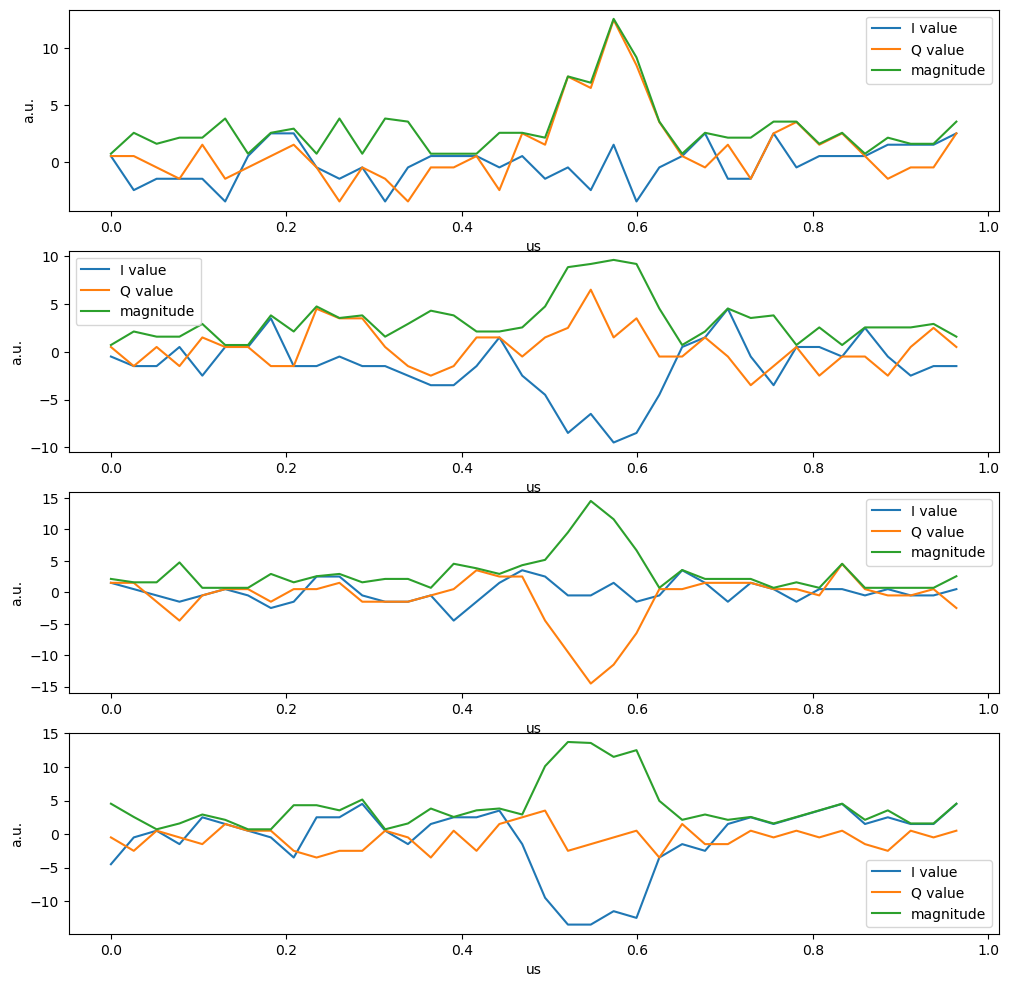

In [45]:
fig, axes = plt.subplots(len(config['ro_chs']), 1, figsize=(12,12))
for i, ch in enumerate(config['ro_chs']):
    plot = axes[i]
    plot.plot(t, iq_list[i][:,0], label="I value")
    plot.plot(t, iq_list[i][:,1], label="Q value")
    plot.plot(t, np.abs(iq_list[i].dot([1,1j])), label="magnitude")
    plot.legend()
    plot.set_ylabel("a.u.")
    plot.set_xlabel("us");

### Printing the program
It's sometimes useful to print the program in ASM format, to get a feeling for what's going on.

In [ ]:
print(prog)